## Table of Contents

* [1.0 Data Cleaning](#1_0)
* [2.0 EDA](#2_0)
* [3.0 Modelling](#3_0)
    * [3.1 Feature Engineering](#3_1)
    * [3.2 Pycaret](#3_2)
* [4.0 Findings and Insights](#4_0)

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as linear_model

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn import ensemble
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB

from pycaret.classification import *
from pycaret.datasets import get_data

In [2]:
df = pd.read_csv("data/image_data.csv") 

In [3]:
df.median()

performance       0.008101
Like number    1880.000000
dtype: float64

## 1.0 Data Cleaning <a class="anchor" id="1_0"></a>

In [4]:
df['overperforming'] = np.where(df['performance']>0.008101, 1, 0)

## 2.0 EDA  <a class="anchor" id="2_0"></a>

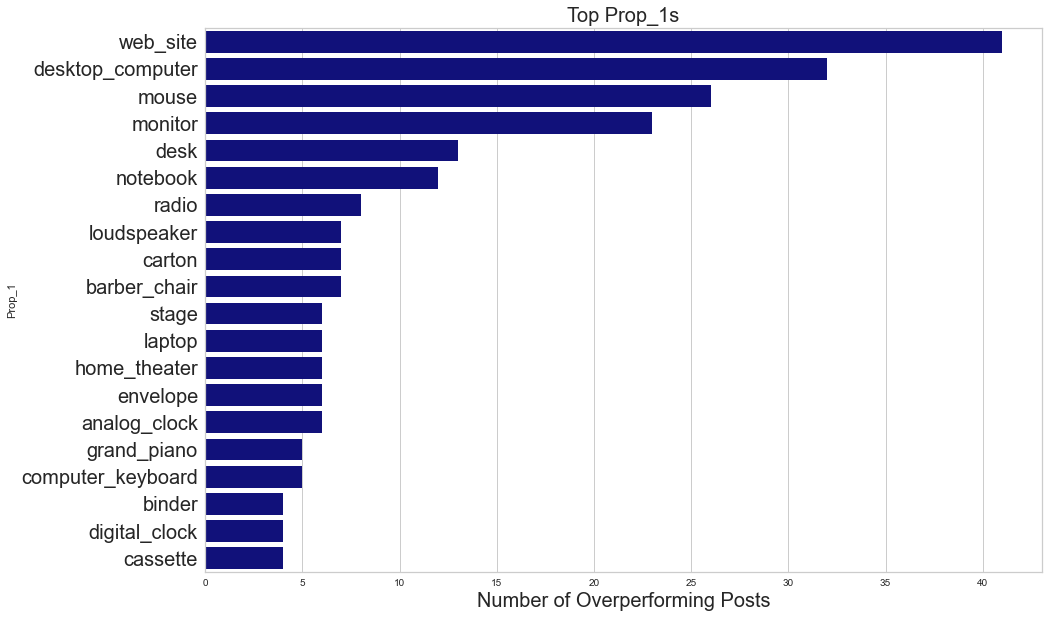

In [46]:
df1 = pd.read_csv("data/image_data.csv") 
df1['overperforming'] = np.where(df['performance']>0.008101, 1, 0)
df1.groupby('Prop_1')['overperforming'].value_counts()
best_prop_1 = df1[df1.overperforming != 0]
best_prop_1_20 = best_prop_1.groupby(['Prop_1']).size().reset_index(name='Count').sort_values(by= 'Count', ascending= False).head(20)

fig, ax = plt.subplots(figsize=(15,10));

sns.barplot(y= best_prop_1_20['Prop_1'], x = best_prop_1_20.Count,color='darkblue',ax=ax);
ax.set_title('Top Prop_1s',fontsize=20);
ax.set_xlabel('Number of Overperforming Posts', fontsize=20);
plt.setp(ax.get_yticklabels(), fontsize=20);

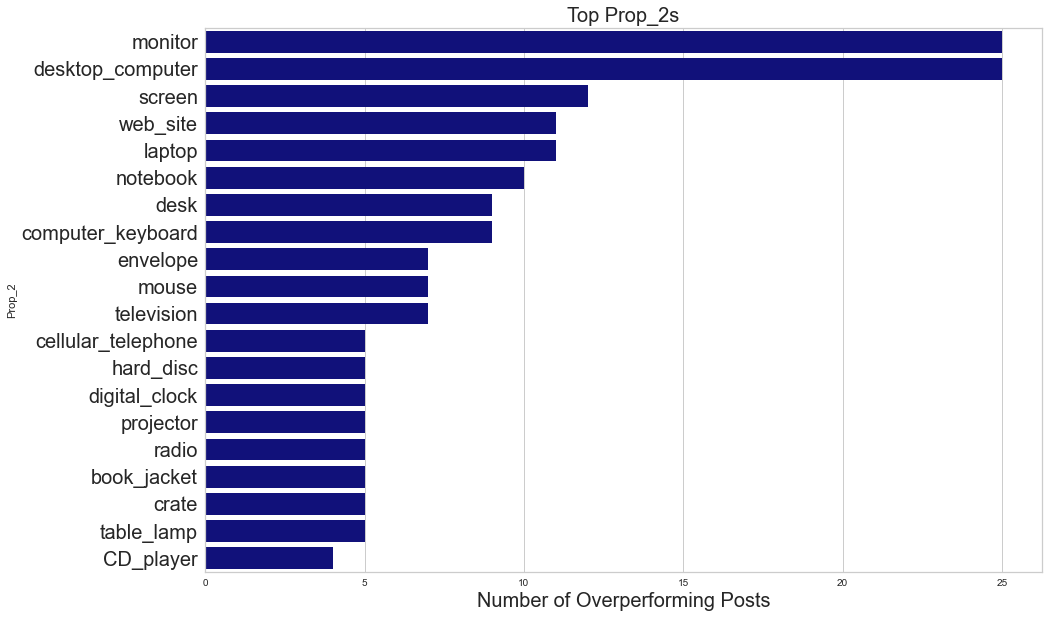

In [49]:
df1.groupby('Prop_2')['overperforming'].value_counts()
best_prop_2 = df1[df1.overperforming != 0]
best_prop_2_20 = best_prop_2.groupby(['Prop_2']).size().reset_index(name='Count').sort_values(by= 'Count', ascending= False).head(20)

fig, ax = plt.subplots(figsize=(15,10));

sns.barplot(y= best_prop_2_20['Prop_2'], x = best_prop_2_20.Count,color='darkblue',ax=ax);
ax.set_title('Top Prop_2s',fontsize=20);
ax.set_xlabel('Number of Overperforming Posts', fontsize=20);
plt.setp(ax.get_yticklabels(), fontsize=20);

Since I did EDA on accounts and post date and time in the non-image model, here I focus on prop eda. We see that for the most prominent prop, most overperforming posts feature a website. For the second most prominent prop, it’s a monitor.

## 3.0 Modelling  <a class="anchor" id="3_0"></a>

### 3.1 Feature Engineering <a class="anchor" id="3_1"></a>

In [5]:
df = pd.get_dummies(df, columns = ['Prop_1', 'Prop_2', 'Prop_3','Prop_4','Prop_5','Prop_6','Prop_7','Prop_8','Prop_9'])

<AxesSubplot:>

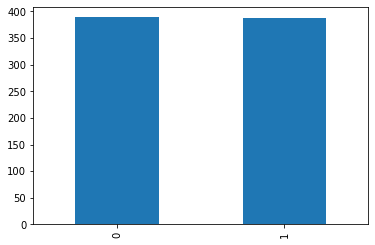

In [6]:
df.overperforming.value_counts().plot(kind = 'bar')

In [7]:
overperforming_posts = df.overperforming.isin([1]).sum()
underperforming_posts = df.overperforming.isin([0]).sum()
print('Number of overperforming posts: ' + str(overperforming_posts))
print('Number of non-overperforming posts: ' + str(underperforming_posts))
print('Baseline = ' + str((overperforming_posts/777)))

Number of overperforming posts: 388
Number of non-overperforming posts: 389
Baseline = 0.49935649935649934


In [8]:
features = df.drop(columns = ['performance', 'Like number', 'brand'])

### 3.2 Pycaret <a class="anchor" id="3_2"></a>

In [9]:
classifiers = setup(data = features, target = 'overperforming', data_split_stratify = True) 

,Description,Value
0,session_id,1633
1,Target,overperforming
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(777, 2266)"
5,Missing Values,False
6,Numeric Features,2265
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [10]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5287,0.5324,0.6126,0.5256,0.5626,0.0580,0.0595,0.0340
lda,Linear Discriminant Analysis,0.5213,0.5241,0.5279,0.5206,0.5220,0.0424,0.0427,0.2170
svm,SVM - Linear Kernel,0.5139,0.0000,0.4839,0.5132,0.4957,0.0281,0.0283,0.0380
ada,Ada Boost Classifier,0.5065,0.5213,0.6327,0.4937,0.5055,0.0163,0.0289,0.3020
lr,Logistic Regression,0.5028,0.5115,0.5056,0.5081,0.5028,0.0060,0.0070,0.9760
ridge,Ridge Classifier,0.4991,0.0000,0.5130,0.4996,0.5038,-0.0017,-0.0013,0.0440
gbc,Gradient Boosting Classifier,0.4991,0.5143,0.5396,0.4826,0.4919,0.0002,0.0005,0.6340
dt,Decision Tree Classifier,0.4954,0.4950,0.3690,0.4879,0.4183,-0.0099,-0.0114,0.1260
rf,Random Forest Classifier,0.4936,0.4835,0.2656,0.4944,0.3375,-0.0139,-0.0126,0.3210
xgboost,Extreme Gradient Boosting,0.4897,0.4816,0.5536,0.4872,0.5145,-0.0193,-0.0196,1.4900


GaussianNB(priors=None, var_smoothing=1e-09)

In [14]:
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4909,0.4418,0.6667,0.4865,0.5625,-0.0118,-0.0127
1,0.4727,0.4815,0.5926,0.4706,0.5246,-0.0500,-0.0517
2,0.5818,0.5708,0.5357,0.6000,0.5660,0.1650,0.1660
3,0.4444,0.4204,0.3333,0.4286,0.3750,-0.1111,-0.1140
4,0.4444,0.4424,0.5185,0.4516,0.4828,-0.1111,-0.1124
5,0.6296,0.7037,0.7407,0.6061,0.6667,0.2593,0.2659
6,0.3889,0.3615,0.3333,0.3750,0.3529,-0.2222,-0.2236
7,0.4074,0.4019,0.5185,0.4242,0.4667,-0.1852,-0.1899
8,0.5000,0.5302,0.6296,0.5000,0.5574,0.0000,0.0000
9,0.5370,0.4616,0.6667,0.5294,0.5902,0.0741,0.0767


In [15]:
tune_xg = tune_model(xgboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4545,0.4735,0.8889,0.4706,0.6154,-0.0742,-0.1451
1,0.5091,0.5688,0.9630,0.5000,0.6582,0.0338,0.0757
2,0.5455,0.5384,0.9643,0.5294,0.6835,0.0766,0.1451
3,0.4815,0.4129,0.8889,0.4898,0.6316,-0.0370,-0.0639
4,0.5556,0.5638,1.0000,0.5294,0.6923,0.1111,0.2425
5,0.5185,0.5782,1.0000,0.5094,0.6750,0.0370,0.1374
6,0.4630,0.4122,0.8148,0.4783,0.6027,-0.0741,-0.1043
7,0.4630,0.4314,0.9259,0.4808,0.6329,-0.0741,-0.1961
8,0.5000,0.5110,0.9630,0.5000,0.6582,0.0000,0.0000
9,0.5556,0.5679,0.9630,0.5306,0.6842,0.1111,0.1917


In [16]:
model_tuned_xg = create_model(tune_xg)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4545,0.4735,0.8889,0.4706,0.6154,-0.0742,-0.1451
1,0.5091,0.5688,0.9630,0.5000,0.6582,0.0338,0.0757
2,0.5455,0.5384,0.9643,0.5294,0.6835,0.0766,0.1451
3,0.4815,0.4129,0.8889,0.4898,0.6316,-0.0370,-0.0639
4,0.5556,0.5638,1.0000,0.5294,0.6923,0.1111,0.2425
5,0.5185,0.5782,1.0000,0.5094,0.6750,0.0370,0.1374
6,0.4630,0.4122,0.8148,0.4783,0.6027,-0.0741,-0.1043
7,0.4630,0.4314,0.9259,0.4808,0.6329,-0.0741,-0.1961
8,0.5000,0.5110,0.9630,0.5000,0.6582,0.0000,0.0000
9,0.5556,0.5679,0.9630,0.5306,0.6842,0.1111,0.1917


## 4.0 Findings and Insights <a class="anchor" id="4_0"></a>

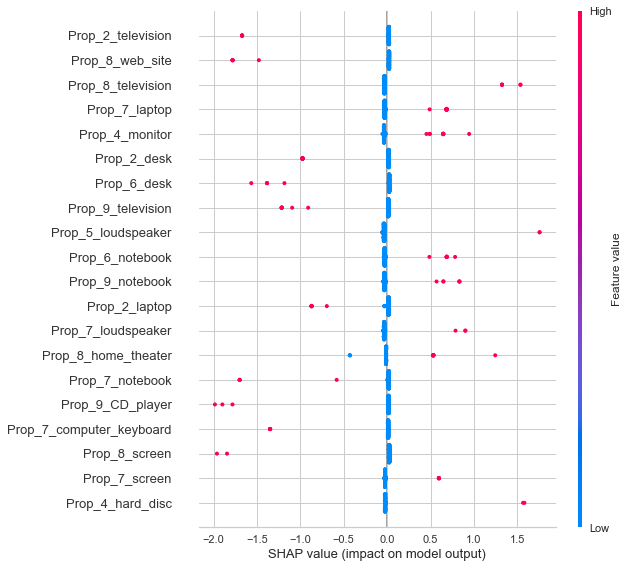

In [17]:
interpret_model(model_tuned_xg)

In [40]:
interpret_model(xgboost, plot = 'reason', observation = 100)

Based on documentation in SHAP which provides us the model interpretation tool in pycaret, features with a high SHAP value as in Prop_8_television, Prop_7_laptop, Prop_4_monitor etc prompts the model to classify the image with a positive value i.e. overperforming. In other words, these props you should have in your Instagram post. As for the props with a negative SHAP value, these prompt the model to predict a post to be underperforming, so we should not include them. Because I was ambitious and wanted to account for prop prominence in each image, as you can see, there are props which belong to both the include and do not include sections. I’ll talk about this more in the limitations and recommendations section in the README.md.